In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tr

import torch_geometric
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch

from typing import Optional, Union

from torch import Tensor
from torch.nn import Linear
from torch_geometric.nn.conv import MessagePassing, GravNetConv
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_scatter import scatter

from tqdm.notebook import tqdm

import numpy as np

import json
import math
import os
import time

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# VICreg loss function
def criterion(x, y, device='cuda', lmbd = 5e-3, u = 1, v= 1, epsilon = 1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T@yNorm) / bs
    cross_loss = (crossCorMat*lmbd - torch.eye(emb, device=torch.device(device))*lmbd).pow(2).sum()

    loss = u*var_loss + v*invar_loss + cross_loss

    return loss

# CLIC

In [3]:
# load the clic dataset
import glob
all_files = glob.glob(f"../data/clic/data_*")

data = []
for f in all_files:
    data += torch.load(f"{f}")

In [205]:
print(f"num of clic events {len(data)}")

num of clic events 7260


In [206]:
loader = torch_geometric.loader.DataLoader(data, batch_size=1)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

A single event: 
 Batch(x=[135, 8], ygen=[135, 5], ygen_id=[135], ycand=[135, 5], ycand_id=[135], batch=[135], ptr=[2])


In [207]:
# function that takes an event~Batch() and splits it into two Batch() objects representing the tracks/clusters
def distinguish_PFelements(batch):
    
    track_id = 0
    cluster_id = 1

    tracks = Batch(x = batch.x[batch.x[:,0]==track_id][:,1:].float(),   # remove the first input feature which is not needed anymore
                  ygen = batch.ygen[batch.x[:,0]==track_id],
                  ygen_id = batch.ygen_id[batch.x[:,0]==track_id],
                  ycand = batch.ycand[batch.x[:,0]==track_id],
                  ycand_id = batch.ycand_id[batch.x[:,0]==track_id],
                  batch = batch.batch[batch.x[:,0]==track_id],
                 )
    clusters = Batch(x = batch.x[batch.x[:,0]==cluster_id][:,1:].float(),   # remove the first input feature which is not needed anymore
                    ygen = batch.ygen[batch.x[:,0]==cluster_id],
                    ygen_id = batch.ygen_id[batch.x[:,0]==cluster_id],
                    ycand = batch.ycand[batch.x[:,0]==cluster_id],
                    ycand_id = batch.ycand_id[batch.x[:,0]==cluster_id],
                    batch = batch.batch[batch.x[:,0]==cluster_id],                    
                   )
    
    return tracks, clusters

In [208]:
tracks, clusters = distinguish_PFelements(batch)

print(f"event:    {batch}")
print(f"tracks:   {tracks}")
print(f"clusters: {clusters}")

event:    Batch(x=[135, 8], ygen=[135, 5], ygen_id=[135], ycand=[135, 5], ycand_id=[135], batch=[135], ptr=[2])
tracks:   Batch(x=[43, 7], ygen=[43, 5], ygen_id=[43], ycand=[43, 5], ycand_id=[43], batch=[43])
clusters: Batch(x=[92, 7], ygen=[92, 5], ygen_id=[92], ycand=[92, 5], ycand_id=[92], batch=[92])


# VICreg

In [226]:
# define the Encoder that learns latent representations of tracks and clusters 
# these representations will be used by MLPF which is the downstream task
class Encoder(nn.Module):

    def __init__(
        self,
        input_dim=7,
        embedding_dim=34,
        output_dim=500,
        num_convs=2,
    ):
        super(Encoder, self).__init__()

#         self.act = nn.ReLU
        self.act = nn.ELU

        ### 1. different embedding of tracks/clusters
        self.nn1 = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )

        ### 2. same GNN for tracks/clusters
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(embedding_dim, embedding_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=16))
        
    def forward(self, tracks, clusters):
  
        embedding_tracks = self.nn1(tracks.x.float())
        embedding_clusters = self.nn2(clusters.x.float())
        
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding_tracks = conv(embedding_tracks, tracks.batch)
            embedding_clusters = conv(embedding_clusters, clusters.batch)
        
        return embedding_tracks, embedding_clusters

In [227]:
# define the decoder that expands the latent representations of tracks and clusters 
class Decoder(nn.Module):

    def __init__(
        self,
        embedding_dim=7,
        output_dim=500,
    ):
        super(Decoder, self).__init__()

#         self.act = nn.ReLU
        self.act = nn.ELU
    
        ############################ DECODER
        self.expander = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, output_dim),
        )
        
    def forward(self, out_tracks, out_clusters):
        
        return self.expander(out_tracks), self.expander(out_clusters)

In [228]:
# retrieve a batch with batch_size>1
loader = torch_geometric.loader.DataLoader(data, batch_size=2)
for batch in loader:
    break

# retrieve the tracks and clusters
tracks, clusters = distinguish_PFelements(batch)

# setup VICreg
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)

# make encoder forward pass
embedding_tracks, embedding_clusters = encoder(tracks, clusters)

# pooling
pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)

# make decoder forward pass
out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

# compute the loss between the two latent representations
loss = criterion(out_tracks, out_clusters, device='cpu')
print('loss is: ', loss.item())

loss is:  6.285714149475098


In [229]:
# train the encoder
def train_VICreg(encoder, decoder, data, batch_size, lr, epochs):

#     data_train = data[:1000]
#     data_val = data[4000:5000]

    data_train = data
    
    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
#     val_loader = torch_geometric.loader.DataLoader(data_val, batch_size)

    optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, momentum= 0.9, weight_decay=1.5e-4)

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []
    
    for epoch in tqdm(range(epochs)):
#         if epoch==10:
#             lr *= 10
        
        encoder.train()
        decoder.train()
        loss_train = 0
        
        for batch in tqdm(train_loader):
            # make transformation
            tracks, clusters = distinguish_PFelements(batch)

            ### ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)
            ### POOLING
            pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
            pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
            ### DECODE
            out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

            # compute loss
            loss = criterion(out_tracks, out_clusters, device='cpu')
            if loss>3000000:
                print(loss)
                break
            
            # update parameters
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None                
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()
            
#         encoder.eval()
#         decoder.eval()
#         loss_valid = 0
#         with torch.no_grad():
#             for batch in tqdm(val_loader):
#                 # make transformation
#                 tracks, clusters = distinguish_PFelements(batch)

#                 ### ENCODE
#                 embedding_tracks, embedding_clusters = encoder(tracks, clusters)
#                 ### POOLING
#                 pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
#                 pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
#                 ### DECODE
#                 out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

#                 # compute loss
#                 loss = criterion(out_tracks, out_clusters, device='cpu')

#                 loss_valid += loss.detach()

        print(f"epoch {epoch} - loss: {round(loss_train.item(),3)}")
#         print(f"epoch {epoch} - train: {round(loss_train.item(),3)} - valid: {round(loss_valid.item(), 3)} - stale={stale_epochs}")

        losses_train.append(loss_train/len(train_loader)) 
#         losses_valid.append(loss_valid/len(val_loader))

#         # early-stopping
#         if losses_valid[epoch] < best_val_loss:
#             best_val_loss = losses_valid[epoch]
#             stale_epochs = 0
#         else:
#             stale_epochs += 1

#     return losses_train, losses_valid
    return losses_train

In [230]:
batch_size = 100
lr = 1e-3
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)
# losses_train, losses_valid = train_VICreg(encoder, decoder, data, batch_size, lr, epochs=10)
losses_train = train_VICreg(encoder, decoder, data, batch_size, lr, epochs=100)


epoch 0 - loss: 146.772



epoch 1 - loss: 135.602



epoch 2 - loss: 134.206



epoch 3 - loss: 133.427



epoch 4 - loss: 132.866



epoch 5 - loss: 132.438



epoch 6 - loss: 132.078



epoch 7 - loss: 131.76



epoch 8 - loss: 131.482



epoch 9 - loss: 131.235



epoch 10 - loss: 131.009



epoch 11 - loss: 130.797



epoch 12 - loss: 130.604



epoch 13 - loss: 130.422



epoch 14 - loss: 130.259



epoch 15 - loss: 130.108



epoch 16 - loss: 129.967



epoch 17 - loss: 129.838



epoch 18 - loss: 129.711



epoch 19 - loss: 129.587



epoch 20 - loss: 129.464



epoch 21 - loss: 129.344



epoch 22 - loss: 129.228



epoch 23 - loss: 129.115



epoch 24 - loss: 129.002



epoch 25 - loss: 128.886



epoch 26 - loss: 128.77



epoch 27 - loss: 128.655



epoch 28 - loss: 128.537



epoch 29 - loss: 128.409



epoch 30 - loss: 128.273



epoch 31 - loss: 128.111



epoch 32 - loss: 127.906



epoch 33 - loss: 127.628



epoch 34 - loss: 127.285



epoch 35 - loss: 126.863



epoch 36 - loss: 126.318



epoch 37 - loss: 125.714



epoch 38 - loss: 124.879



epoch 39 - loss: 124.117



epoch 40 - loss: 122.75



epoch 41 - loss: 121.089



epoch 42 - loss: 119.32



epoch 43 - loss: 117.735



epoch 44 - loss: 116.267



epoch 45 - loss: 114.853



epoch 46 - loss: 114.17



epoch 47 - loss: 113.736



epoch 48 - loss: 114.67



epoch 49 - loss: 114.126



epoch 50 - loss: 113.131



epoch 51 - loss: 113.015



epoch 52 - loss: 112.768



epoch 53 - loss: 112.622



epoch 54 - loss: 112.557



epoch 55 - loss: 112.381



epoch 56 - loss: 112.225



epoch 57 - loss: 112.059



epoch 58 - loss: 111.944



epoch 59 - loss: 111.791



epoch 60 - loss: 111.694



epoch 61 - loss: 111.614



epoch 62 - loss: 111.564



epoch 63 - loss: 111.488



epoch 64 - loss: 111.432



epoch 65 - loss: 111.355



epoch 66 - loss: 111.332



epoch 67 - loss: 111.258



epoch 68 - loss: 111.226



epoch 69 - loss: 111.164



epoch 70 - loss: 111.115



epoch 71 - loss: 111.063



epoch 72 - loss: 111.019



epoch 73 - loss: 110.957



epoch 74 - loss: 110.92



epoch 75 - loss: 110.871



epoch 76 - loss: 110.853



epoch 77 - loss: 110.808



epoch 78 - loss: 110.781



epoch 79 - loss: 110.755



epoch 80 - loss: 110.727



epoch 81 - loss: 110.689



epoch 82 - loss: 110.676



epoch 83 - loss: 110.64



epoch 84 - loss: 110.663



epoch 85 - loss: 110.628



epoch 86 - loss: 110.641



epoch 87 - loss: 110.625



epoch 88 - loss: 110.634



epoch 89 - loss: 110.645



epoch 90 - loss: 110.67



epoch 91 - loss: 110.704



epoch 92 - loss: 110.694



epoch 93 - loss: 110.733



epoch 94 - loss: 110.704



epoch 95 - loss: 110.725



epoch 96 - loss: 110.692



epoch 97 - loss: 110.696



epoch 98 - loss: 110.637



epoch 99 - loss: 110.612



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


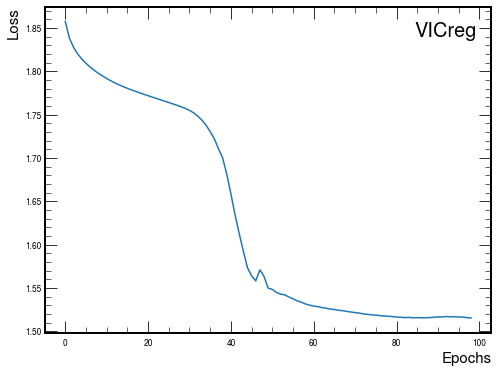

In [238]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_train[1:])), losses_train[1:])#, label="training")
# ax.plot(range(len(losses_valid[1:])), losses_valid[1:], label="validation")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='VICreg', loc="best", title_fontsize=20, fontsize=15);

# Train MLPF

In [221]:
class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=7,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF, self).__init__()

        # self.act = nn.ReLU
        self.act = nn.ELU

        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(input_dim, input_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=k))

        # classifiying pid
        self.nn = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )


    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(input_, batch)

        # predict the pid's
        preds_id = self.nn(embedding)

        return preds_id

In [222]:
# combine the learned latent representations back into one Batch() object that will be the input to MLPF
def combine_PFelements(tracks, clusters):
    
    event = Batch(x = torch.cat([tracks.x, clusters.x]),
                  ygen = torch.cat([tracks.ygen, clusters.ygen]),
                  ygen_id = torch.cat([tracks.ygen_id, clusters.ygen_id]),
                  ycand = torch.cat([tracks.ycand, clusters.ycand]),
                  ycand_id = torch.cat([tracks.ycand_id, clusters.ycand_id]),
                  batch = torch.cat([tracks.batch, clusters.batch]),
                 )
    
    return event

In [223]:
def compute_weights(target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights

def train_mlpf(data, batch_size, model, with_VICreg, epochs):
        
    data_train = data[:1000]
    data_val = data[4000:5000]
    data_test = data[5000:]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    val_loader = torch_geometric.loader.DataLoader(data_val, batch_size)
    test_loader = torch_geometric.loader.DataLoader(data_test, batch_size)
    
    lr = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum= 0.9, weight_decay=1.5e-4)

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    encoder.eval()
    decoder.eval()    

    for epoch in tqdm(range(epochs)):

        model.train()
        loss_train = 0
        for batch in tqdm(train_loader):
            if with_VICreg:
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                # use the learnt representation as your input as well as the global feature vector
                tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch
                
            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
            loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

            # update parameters
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()

            
        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                if with_VICreg:            
                    # make transformation
                    tracks, clusters = distinguish_PFelements(batch)

                    ### ENCODE
                    embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                    ### POOLING
                    pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                    pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                    ### DECODE
                    out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                    # use the learnt representation as your input as well as the global feature vector
                    tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                    clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                    event = combine_PFelements(tracks, clusters)

                else:
                    event = batch

                # make mlpf forward pass
                pred_ids_one_hot = model(event)
                pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
                target_ids = event.ygen_id

                weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
                loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

                loss_valid += loss.detach()

        print(f"epoch {epoch} - train: {round(loss_train.item(),3)} - valid: {round(loss_valid.item(), 3)} - stale={stale_epochs}")

        losses_train.append(loss_train/len(train_loader)) 
        losses_valid.append(loss_valid/len(val_loader))

        # early-stopping
        if losses_valid[epoch] < best_val_loss:
            best_val_loss = losses_valid[epoch]
            stale_epochs = 0
        else:
            stale_epochs += 1
            
    fig, ax = plt.subplots()
    ax.plot(range(len(losses_train[1:])), losses_train[1:], label="training")
    ax.plot(range(len(losses_valid[1:])), losses_valid[1:], label="validation")
    ax.set_xlabel("Epochs", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    if with_VICreg:
        ax.legend(title='ssl MLPF', loc="best", title_fontsize=20, fontsize=15);
    else:
        ax.legend(title='native MLPF', loc="best", title_fontsize=20, fontsize=15);
    return losses_train, losses_valid


epoch 0 - train: 36.921 - valid: 31.777 - stale=0



epoch 1 - train: 29.27 - valid: 28.394 - stale=0



epoch 2 - train: 27.38 - valid: 26.864 - stale=0



epoch 3 - train: 26.372 - valid: 25.87 - stale=0



epoch 4 - train: 25.948 - valid: 25.437 - stale=0



epoch 5 - train: 25.106 - valid: 24.856 - stale=0



epoch 6 - train: 24.656 - valid: 24.478 - stale=0



epoch 7 - train: 24.302 - valid: 24.163 - stale=0



epoch 8 - train: 23.997 - valid: 23.88 - stale=0



epoch 9 - train: 23.723 - valid: 23.623 - stale=0



epoch 10 - train: 23.474 - valid: 23.387 - stale=0



epoch 11 - train: 23.247 - valid: 23.177 - stale=0



epoch 12 - train: 23.063 - valid: 23.061 - stale=0



epoch 13 - train: 22.967 - valid: 22.962 - stale=0



epoch 14 - train: 22.755 - valid: 22.668 - stale=0



epoch 15 - train: 22.499 - valid: 22.43 - stale=0



epoch 16 - train: 22.285 - valid: 22.235 - stale=0



epoch 17 - train: 22.102 - valid: 22.08 - stale=0



epoch 18 - train: 21.948 - valid: 21.939 - stale=0



epoch 19 - train: 21.792 - valid: 21.782 - stale=0



epoch 20 - train: 21.639 - valid: 21.634 - stale=0



epoch 21 - train: 21.497 - valid: 21.499 - stale=0



epoch 22 - train: 21.363 - valid: 21.37 - stale=0



epoch 23 - train: 21.233 - valid: 21.248 - stale=0



epoch 24 - train: 21.108 - valid: 21.131 - stale=0



epoch 25 - train: 20.988 - valid: 21.019 - stale=0



epoch 26 - train: 20.875 - valid: 20.911 - stale=0



epoch 27 - train: 20.765 - valid: 20.807 - stale=0



epoch 28 - train: 20.661 - valid: 20.707 - stale=0



epoch 29 - train: 20.561 - valid: 20.612 - stale=0



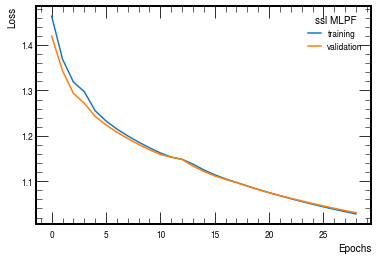

In [232]:
# train ssl version of MLPF
batch_size = 50

input_dim = 7
embedding_dim = encoder.nn1[-1].out_features
out_dim = decoder.expander[-1].out_features

model_ssl = MLPF(input_dim + embedding_dim + out_dim)
losses_train_ssl, losses_valid_ssl = train_mlpf(data, batch_size, model_ssl, with_VICreg=True, epochs=30)

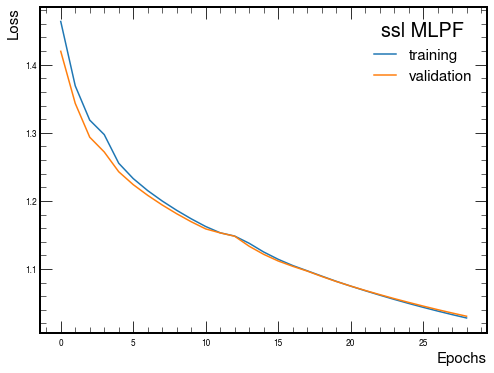

In [236]:
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(range(len(losses_train_ssl[1:])), losses_train_ssl[1:], label="training")
    ax.plot(range(len(losses_valid_ssl[1:])), losses_valid_ssl[1:], label="validation")
    ax.set_xlabel("Epochs", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    ax.legend(title='ssl MLPF', loc="best", title_fontsize=20, fontsize=15);



epoch 0 - train: 251.149 - valid: 51.05 - stale=0



epoch 1 - train: 55.495 - valid: 39.8 - stale=0



epoch 2 - train: 36.758 - valid: 31.603 - stale=0



epoch 3 - train: 29.846 - valid: 28.011 - stale=0



epoch 4 - train: 26.871 - valid: 25.957 - stale=0



epoch 5 - train: 25.283 - valid: 24.76 - stale=0



epoch 6 - train: 24.286 - valid: 23.962 - stale=0



epoch 7 - train: 23.604 - valid: 23.473 - stale=0



epoch 8 - train: 23.425 - valid: 23.445 - stale=0



epoch 9 - train: 23.114 - valid: 22.932 - stale=0



epoch 10 - train: 22.665 - valid: 22.574 - stale=0



epoch 11 - train: 22.34 - valid: 22.296 - stale=0



epoch 12 - train: 22.073 - valid: 22.055 - stale=0



epoch 13 - train: 21.841 - valid: 21.839 - stale=0



epoch 14 - train: 21.634 - valid: 21.645 - stale=0



epoch 15 - train: 21.448 - valid: 21.468 - stale=0



epoch 16 - train: 21.279 - valid: 21.306 - stale=0



epoch 17 - train: 21.124 - valid: 21.159 - stale=0



epoch 18 - train: 20.982 - valid: 21.023 - stale=0



epoch 19 - train: 20.851 - valid: 20.899 - stale=0



epoch 20 - train: 20.731 - valid: 20.783 - stale=0



epoch 21 - train: 20.619 - valid: 20.676 - stale=0



epoch 22 - train: 20.514 - valid: 20.576 - stale=0



epoch 23 - train: 20.417 - valid: 20.482 - stale=0



epoch 24 - train: 20.327 - valid: 20.396 - stale=0



epoch 25 - train: 20.242 - valid: 20.314 - stale=0



epoch 26 - train: 20.162 - valid: 20.238 - stale=0



epoch 27 - train: 20.088 - valid: 20.167 - stale=0



epoch 28 - train: 20.017 - valid: 20.1 - stale=0



epoch 29 - train: 19.951 - valid: 20.038 - stale=0



epoch 30 - train: 19.888 - valid: 19.979 - stale=0



epoch 31 - train: 19.829 - valid: 19.924 - stale=0



epoch 32 - train: 19.773 - valid: 19.872 - stale=0



epoch 33 - train: 19.721 - valid: 19.823 - stale=0



epoch 34 - train: 19.671 - valid: 19.777 - stale=0



epoch 35 - train: 19.625 - valid: 19.733 - stale=0



epoch 36 - train: 19.581 - valid: 19.691 - stale=0



epoch 37 - train: 19.539 - valid: 19.652 - stale=0



epoch 38 - train: 19.499 - valid: 19.615 - stale=0



epoch 39 - train: 19.462 - valid: 19.58 - stale=0



epoch 40 - train: 19.426 - valid: 19.547 - stale=0



epoch 41 - train: 19.392 - valid: 19.515 - stale=0



epoch 42 - train: 19.36 - valid: 19.485 - stale=0



epoch 43 - train: 19.329 - valid: 19.456 - stale=0



epoch 44 - train: 19.3 - valid: 19.429 - stale=0



epoch 45 - train: 19.272 - valid: 19.403 - stale=0



epoch 46 - train: 19.246 - valid: 19.379 - stale=0



epoch 47 - train: 19.22 - valid: 19.355 - stale=0



epoch 48 - train: 19.195 - valid: 19.333 - stale=0



epoch 49 - train: 19.172 - valid: 19.311 - stale=0



epoch 50 - train: 19.15 - valid: 19.291 - stale=0



epoch 51 - train: 19.128 - valid: 19.271 - stale=0



epoch 52 - train: 19.107 - valid: 19.252 - stale=0



epoch 53 - train: 19.087 - valid: 19.234 - stale=0



epoch 54 - train: 19.068 - valid: 19.217 - stale=0



epoch 55 - train: 19.049 - valid: 19.2 - stale=0



epoch 56 - train: 19.031 - valid: 19.183 - stale=0



epoch 57 - train: 19.013 - valid: 19.167 - stale=0



epoch 58 - train: 18.996 - valid: 19.152 - stale=0



epoch 59 - train: 18.98 - valid: 19.137 - stale=0



epoch 60 - train: 18.964 - valid: 19.122 - stale=0



epoch 61 - train: 18.948 - valid: 19.108 - stale=0



epoch 62 - train: 18.933 - valid: 19.095 - stale=0



epoch 63 - train: 18.918 - valid: 19.081 - stale=0



epoch 64 - train: 18.904 - valid: 19.068 - stale=0



epoch 65 - train: 18.889 - valid: 19.055 - stale=0



epoch 66 - train: 18.876 - valid: 19.043 - stale=0



epoch 67 - train: 18.862 - valid: 19.031 - stale=0



epoch 68 - train: 18.849 - valid: 19.019 - stale=0



epoch 69 - train: 18.836 - valid: 19.008 - stale=0



epoch 70 - train: 18.824 - valid: 18.997 - stale=0



epoch 71 - train: 18.812 - valid: 18.986 - stale=0



epoch 72 - train: 18.8 - valid: 18.976 - stale=0



epoch 73 - train: 18.788 - valid: 18.966 - stale=0



epoch 74 - train: 18.777 - valid: 18.956 - stale=0



epoch 75 - train: 18.766 - valid: 18.947 - stale=0



epoch 76 - train: 18.756 - valid: 18.938 - stale=0



epoch 77 - train: 18.745 - valid: 18.929 - stale=0



epoch 78 - train: 18.735 - valid: 18.92 - stale=0



epoch 79 - train: 18.725 - valid: 18.912 - stale=0



epoch 80 - train: 18.715 - valid: 18.904 - stale=0



epoch 81 - train: 18.706 - valid: 18.896 - stale=0



epoch 82 - train: 18.696 - valid: 18.888 - stale=0



epoch 83 - train: 18.687 - valid: 18.88 - stale=0



epoch 84 - train: 18.678 - valid: 18.872 - stale=0



epoch 85 - train: 18.669 - valid: 18.864 - stale=0



epoch 86 - train: 18.66 - valid: 18.857 - stale=0



epoch 87 - train: 18.651 - valid: 18.85 - stale=0



epoch 88 - train: 18.643 - valid: 18.843 - stale=0



epoch 89 - train: 18.634 - valid: 18.836 - stale=0



epoch 90 - train: 18.626 - valid: 18.829 - stale=0



epoch 91 - train: 18.618 - valid: 18.822 - stale=0



epoch 92 - train: 18.61 - valid: 18.815 - stale=0



epoch 93 - train: 18.602 - valid: 18.809 - stale=0



epoch 94 - train: 18.595 - valid: 18.802 - stale=0



epoch 95 - train: 18.587 - valid: 18.796 - stale=0



epoch 96 - train: 18.58 - valid: 18.79 - stale=0



epoch 97 - train: 18.572 - valid: 18.784 - stale=0



epoch 98 - train: 18.565 - valid: 18.778 - stale=0



epoch 99 - train: 18.558 - valid: 18.772 - stale=0



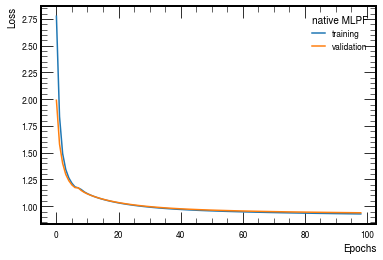

In [17]:
# train native MLPF
batch_size = 50
model = MLPF(input_dim=8)
losses_train, losses_valid = train_mlpf(data, batch_size, model, with_VICreg=False, epochs=100)

## Evaluate the SSL against native MLPF

In [248]:
def evaluate_mlpf(model, with_VICreg):
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes))

    model.eval()
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test_loader)):
            if with_VICreg:
                 # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                # use the learnt representation as your input as well as the global feature vector
                tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch

            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            conf_matrix += sklearn.metrics.confusion_matrix(
                target_ids.detach().cpu(), pred_ids.detach().cpu(), labels=range(num_classes)
            )
    return conf_matrix

CLASS_NAMES_CLIC_LATEX = ["none", "chhad", "nhad", "$\gamma$", "$e^\pm$", "$\mu^\pm$"]

def plot_conf_matrix(cm, title):
    import itertools

    cmap = plt.get_cmap("Blues")
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(8, 6))

    ax = plt.axes()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            "{:0.2f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black", fontsize=15
        )
    plt.title(title, fontsize=25)
    plt.xlabel("Predicted label", fontsize=15)
    plt.ylabel("True label", fontsize=15)

    plt.xticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, rotation=45, fontsize=15)
    plt.yticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, fontsize=15)

    plt.tight_layout()

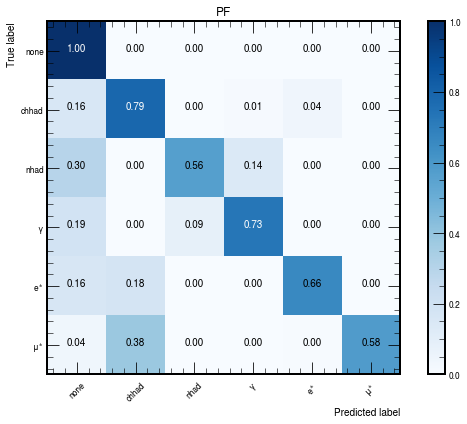

In [165]:
# make confusion matrix of PF for comparison
batch_size = 50

num_classes = 6
conf_matrix_pf = np.zeros((num_classes, num_classes))

test_loader = torch_geometric.loader.DataLoader(data[5000:], batch_size)   
for i, batch in tqdm(enumerate(test_loader)):

    # make mlpf forward pass
    target_ids = batch.ygen_id
    pred_ids = batch.ycand_id
    
    conf_matrix_pf += sklearn.metrics.confusion_matrix(
        target_ids.detach().cpu(), pred_ids.detach().cpu(), labels=range(num_classes)
    )
plot_conf_matrix(conf_matrix_pf, 'PF')

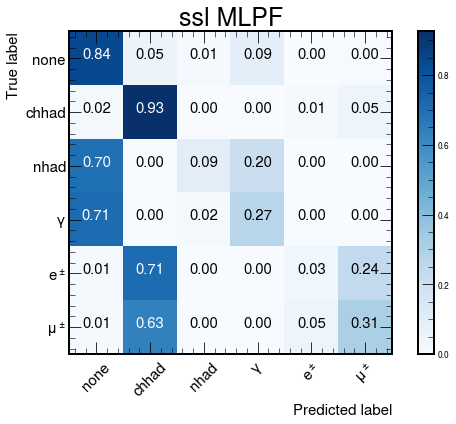

In [249]:
batch_size = 100
# conf_matrix_ssl = evaluate_mlpf(model_ssl, with_VICreg=True)
plot_conf_matrix(conf_matrix_ssl, 'ssl MLPF')

In [204]:
conf_matrix = evaluate_mlpf(model, with_VICreg=False)
plot_conf_matrix(conf_matrix, 'native MLPF')

TypeError: forward() missing 1 required positional argument: 'clusters'